In [114]:
import pandas as pd, numpy as np, mglearn, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px,umap, pickle, plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
train_x = pd.read_csv('Data/X_train.csv',header=None)
train_y = pd.read_csv('Data/y_train.csv',header=None).values.reshape(-1)
test_x = pd.read_csv('Data/X_test.csv',header=None)
test_y = pd.read_csv('Data/y_test.csv',header=None).values.reshape(-1)

In [3]:
train_x.shape

(25000, 1000)

In [4]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
train_model = True
save = True

In [5]:
def make_df(model_list,opt_list):
    #Edited from my final last semester for simpler models
    #Since not all models require the same option lists, we can run this on each pairing and merge.
    result = []
    for model_gen in model_list:
        for option in opt_list:
            model_id, model = model_gen(option)
            result.append([f'{model_id}_{option:.2f}', model_id, model,option])
    return pd.DataFrame(columns = ['ID','Model_ID','Model', 'Attribute'],data=result)
def rbf(distances):
    return np.exp(-distances**2/(2))
# def knn(neighbor):
#     return inspect.stack()[0][3], KNeighborsClassifier(n_neighbors=int(neighbor)) #I know this can cause issues, but it's worth it for this.

In [109]:
def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res):
    res['mean_score'] = res[['mean_train_score','mean_test_score']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res['std_score'] = res[['std_train_score','std_test_score']].values.tolist()
    res = res.explode(['mean_score','type','std_score'],ignore_index=True)
    return res

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model'):
    test = seaborn_friendly(res)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        ax = sns.lineplot(x=x, y='mean_score',hue=param,style='type',data=test)
        ax.set(title="{} Avg Performance by {}".format(key.upper(),param))
        if save:
            ax.get_figure().savefig(Path(out_dir,"{}_performance_{}.png".format(param,x)))
        show()

In [7]:
if train_model:
    distance_options = ['uniform','distance',rbf]
    neighbor_options = np.arange(20) + 1 #Set to be higher later tonight
    knn_grid = {'n_neighbors':neighbor_options, 'weights':distance_options}
    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, knn_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    knn_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'knn_cv.pkl'),'wb') as fil:
            pickle.dump(knn_cv, fil)
    del(knn_cv)

    nb = MultinomialNB()
    alphas = np.linspace(0.01, 5, 10) # Set to be more later tonight (was 51)
    nb_grid = {'alpha':alphas, 'fit_prior':[True, False]}
    nb_cv = GridSearchCV(nb, nb_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    nb_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'nb_cv.pkl'),'wb') as fil:
            pickle.dump(nb_cv, fil)
    del(nb_cv)

    rf = RandomForestClassifier()
    estimators = np.arange(100, 500, 100) # Originally 100, 1000, 100
    max_depth = list(range(10,60, 20)) 
    max_depth.append(None)
    max_features = ['sqrt']#,'log2']
    rf_grid = {'n_estimators':estimators, 'max_depth':max_depth, 'max_features':max_features}
    rf_cv = GridSearchCV(rf, rf_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    rf_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'rf_cv.pkl'),'wb') as fil:
            pickle.dump(rf_cv, fil)
    del(rf_cv)

    gb = GradientBoostingClassifier()
    losses = ['log_loss']#,'exponential']
    learning_rates = np.linspace(.01, 2, 10)
    n_estimators = np.arange(100,500, 100)
    gb_grid = {'loss':losses,'learning_rate' : learning_rates, "n_estimators":n_estimators}
    gb_cv = GridSearchCV(gb, gb_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    gb_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'gb_cv.pkl'),'wb') as fil:
            pickle.dump(gb_cv, fil)
    del(gb_cv)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 3/4; 1/60] START n_neighbors=1, weights=uniform.............................[CV 2/4; 1/60] START n_neighbors=1, weights=uniform.............................

[CV 2/4; 2/60] START n_neighbors=1, weights=distance............................
[CV 1/4; 1/60] START n_neighbors=1, weights=uniform.............................
[CV 4/4; 2/60] START n_neighbors=1, weights=distance............................[CV 1/4; 3/60] START n_neighbors=1, weights=<function rbf at 0x7fe5f50459d0>....[CV 1/4; 2/60] START n_neighbors=1, weights=distance............................


[CV 4/4; 1/60] START n_neighbors=1, weights=uniform.............................
[CV 3/4; 2/60] START n_neighbors=1, weights=distance............................
[CV 2/4; 3/60] START n_neighbors=1, weights=<function rbf at 0x7fb4d02cf9d0>....
[CV 1/4; 4/60] START n_neighbors=2, weights=uniform.............................
[CV 4/4; 3/60] START n_neighbors=1, weights=<fu

In [8]:
knn = load_model('knn')

In [34]:
res = pd.DataFrame.from_dict(knn.cv_results_)
res.loc[res['param_weights'] == rbf,'param_weights'] = 'rbf'
res.shape

(60, 20)

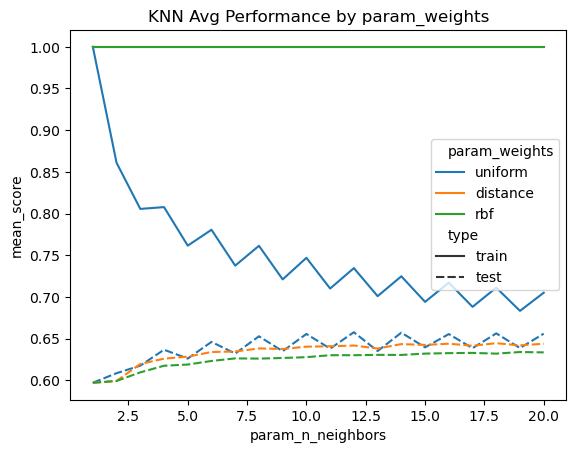

In [67]:
plot_cv_param_res(res,'param_n_neighbors','param_weights',key='knn')

In [121]:
def analyze(key, x, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    if 'rf' in key:
        #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
        mask = df['param_max_depth'].isna()
        df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    ys = df.filter(regex='param').columns
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
    ys = ys.drop(droppables)
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    for param in ys:
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key)
    return df
    
def contour_continuous(df, x, y, title='placeholder'):
    fig = go.Figure(data= go.Contour(z=df['mean_test_score'],x=df[x],y = df[y]))
    fig.update_layout(title=title, xaxis_title=y, yaxis_title=y)
    fig.show()

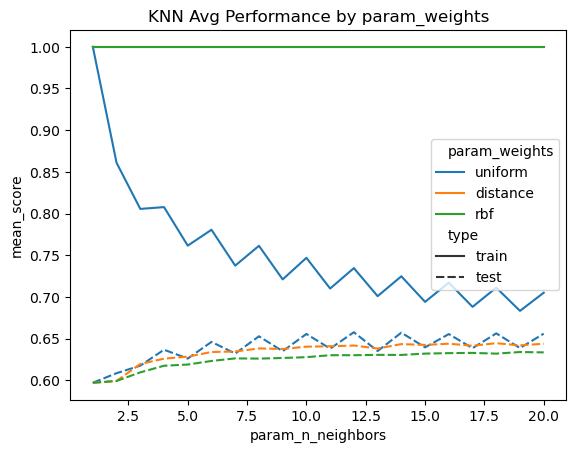

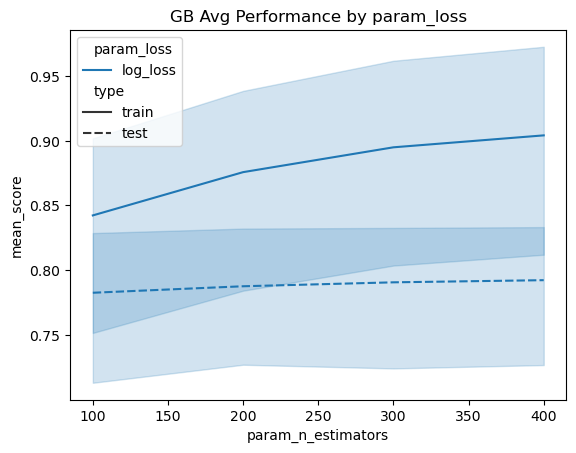

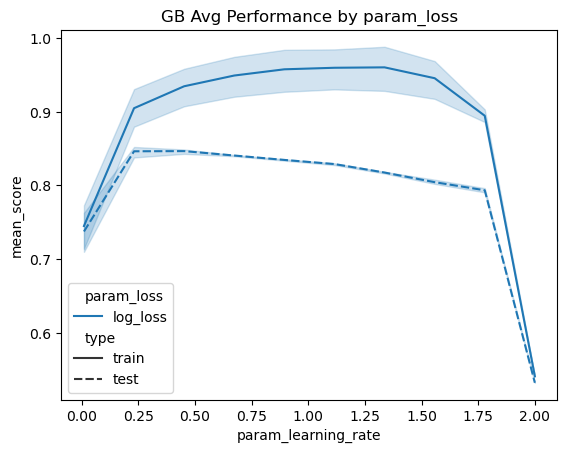

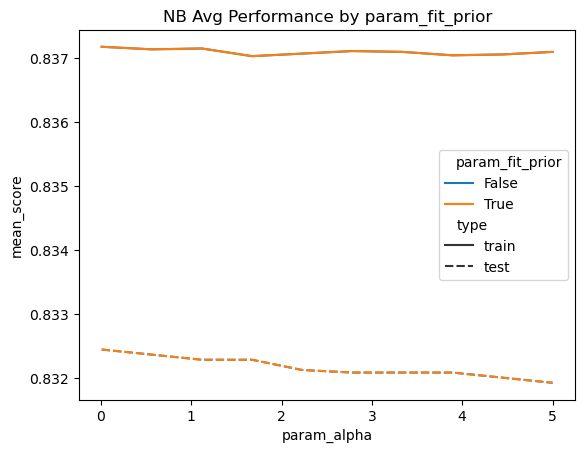

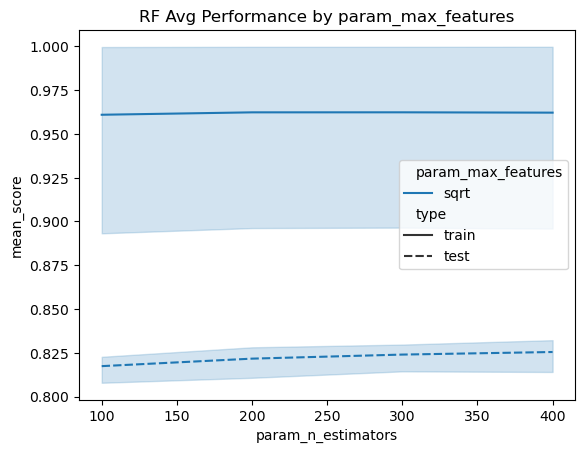

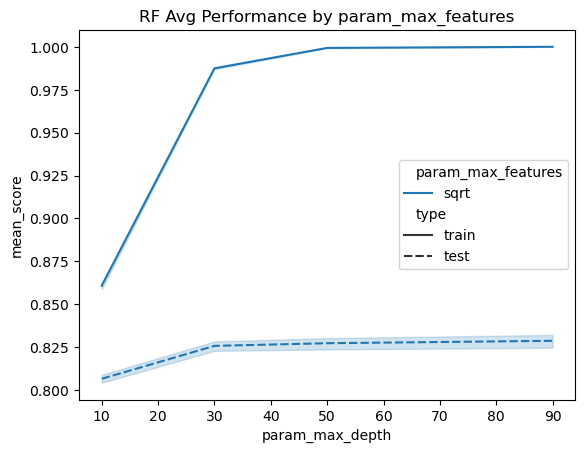

In [113]:
keys = ['knn','gb','nb','rf']
xs = ['param_n_neighbors',['param_n_estimators','param_learning_rate'],'param_alpha',['param_n_estimators','param_max_depth']]
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, save=True, out_dir=res_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
    


In [68]:
# model_res = load_model('gb')
# df =  pd.DataFrame.from_dict(model_res.cv_results_)
# df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_fit_prior', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [115]:
df = df_dict['gb']
x = 'param_learning_rate'
y = 'param_n_estimators'
contour_continuous(df,x,y,'GB Continuous Test Accuracy')

In [128]:
df = df_dict['rf']
x = 'param_max_depth'
y = 'param_n_estimators'
contour_continuous(df,x,y,'RF Continuous Test Accuracy')

In [104]:
df.loc[diffmask, 'param_max_depth'].diff()

4          NaN
8           20
12    7.272727
Name: param_max_depth, dtype: object

In [101]:
mask.shape

(16,)

In [102]:
diffmask.shape

(16,)